In [124]:
print("✅ Jupyter is working!")

✅ Jupyter is working!


In [125]:
import sqlite3

conn = sqlite3.connect("fantasy_football.db")  # now inside notebooks/
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
conn.close()

print(tables)

[('seasons',), ('players',), ('rosters',), ('matchups',), ('schedules',), ('playoffs',), ('draft_results',), ('standings',), ('box_scores',), ('teams',)]


In [126]:
import sqlite3
import pandas as pd

# Connect to your fantasy football database
conn = sqlite3.connect("../db/fantasy_football.db")
# Load draft results with player and team info
query = """
SELECT 
    d.season_year,
    d.round,
    d.pick,
    p.name AS player_name,
    p.position,
    p.team,
    t.owner_name,
    sp.total_points
FROM draft_results d
JOIN players p ON d.player_id = p.player_id
JOIN teams t ON d.team_id = t.team_id AND d.season_year = t.season_year
LEFT JOIN player_season_points sp ON d.player_id = sp.player_id AND d.season_year = sp.season_year
ORDER BY d.season_year, d.round, d.pick
"""
df = pd.read_sql_query(query, conn)
df.head()

,season_year,round,pick,player_name,position,team,owner_name,total_points
0,2019,1,1,Le'Veon Bell,RB,None,Maxwell Sutterlin,139.0
1,2019,1,2,Saquon Barkley,RB,None,carter tyzinski,203.0
2,2019,1,3,Ezekiel Elliott,RB,None,Matt Kenney,227.0
3,2019,1,4,DeAndre Hopkins,WR,None,Cam Beaury,159.0
4,2019,1,5,David Johnson,RB,None,Collin Love,95.0


/Users/arankirwan/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


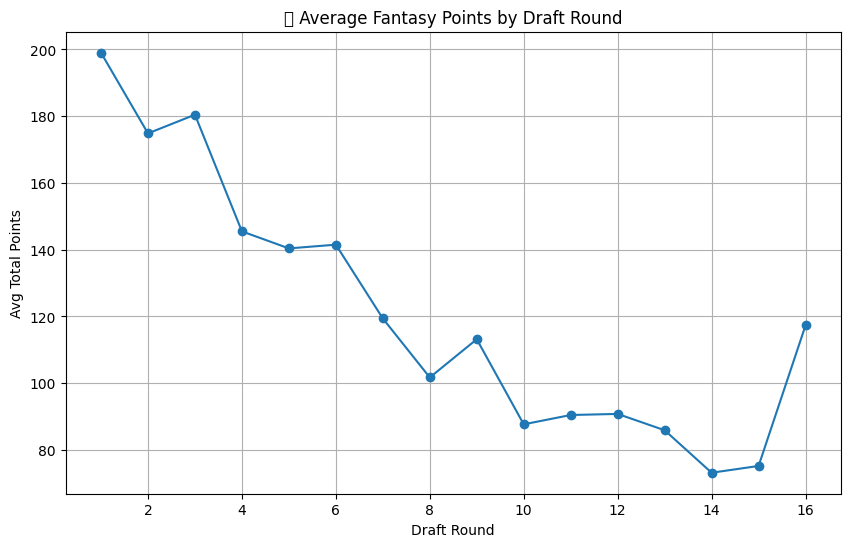

In [127]:
import matplotlib.pyplot as plt

# Group by round, then get average total points
roi_by_round = df.groupby("round")["total_points"].mean().reset_index()

# Plot it
plt.figure(figsize=(10, 6))
plt.plot(roi_by_round["round"], roi_by_round["total_points"], marker="o")
plt.title("📈 Average Fantasy Points by Draft Round")
plt.xlabel("Draft Round")
plt.ylabel("Avg Total Points")
plt.grid(True)
plt.show()

In [128]:
# Manual owner name corrections
owner_corrections = {
    "Jane Sutterlin": "Maxwell Sutterlin",
    "Devin Fiorante, Devin Fiorante": "Devin Fiorante",
    "Mike Krider, Michael Krider": "Mike Krider",
    # Add more if needed
}

# Apply corrections
df["owner_name"] = df["owner_name"].replace(owner_corrections)

In [129]:
# Group by team, then get average draft pick performance
roi_by_team = df.groupby("owner_name")["total_points"].mean().reset_index()
roi_by_team = roi_by_team.sort_values("total_points", ascending=False)

roi_by_team.head()

,owner_name,total_points
7,Maxwell Sutterlin,133.500000
4,Devin Fiorante,131.500000
0,Alan Sutterlin,130.312500
10,Will Pryor,127.500000
6,Matt Kenney,125.571429


/Users/arankirwan/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


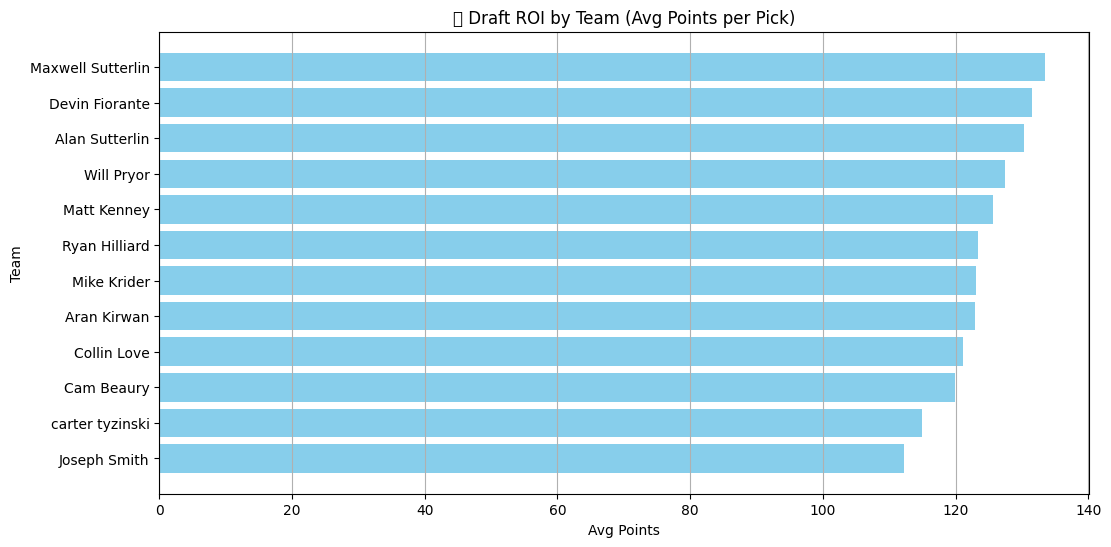

In [130]:
plt.figure(figsize=(12, 6))
plt.barh(roi_by_team["owner_name"], roi_by_team["total_points"], color="skyblue")
plt.title("🏆 Draft ROI by Team (Avg Points per Pick)")
plt.xlabel("Avg Points")
plt.ylabel("Team")
plt.gca().invert_yaxis()
plt.grid(True, axis='x')
plt.show()

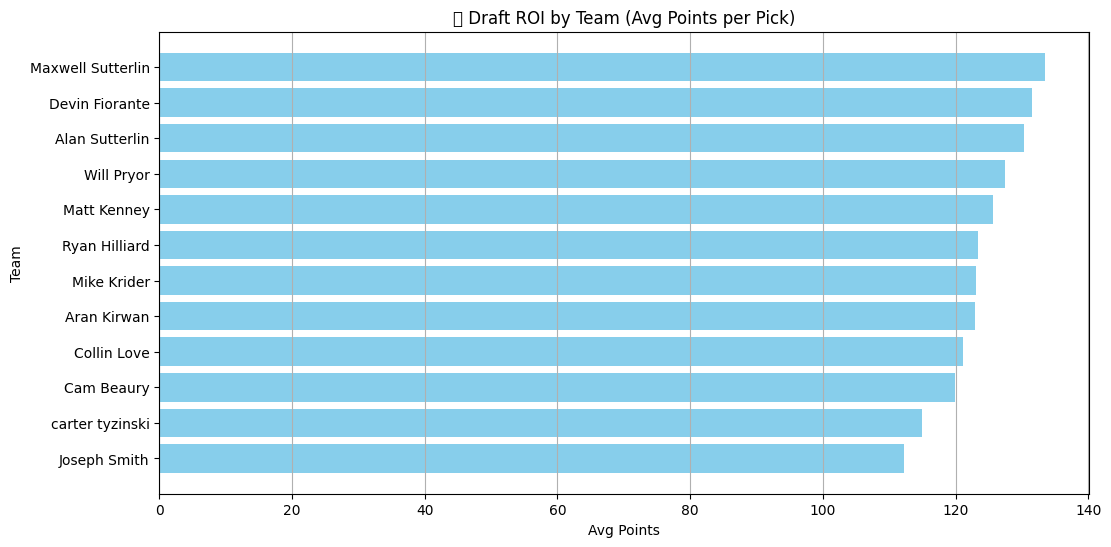

In [131]:
plt.figure(figsize=(12, 6))
plt.barh(roi_by_team["owner_name"], roi_by_team["total_points"], color="skyblue")
plt.title("🏆 Draft ROI by Team (Avg Points per Pick)")
plt.xlabel("Avg Points")
plt.ylabel("Team")
plt.gca().invert_yaxis()
plt.grid(True, axis='x')
plt.show()

In [132]:
# Normalize points by round (you could use log scale or just invert round number)
df["normalized_roi"] = df["total_points"] / (df["round"] + 1)  # +1 to avoid division by zero

In [133]:
# Add a column with bonus ROI points
df["bonus_points"] = df.apply(
    lambda row: 20 if row["round"] >= 10 and row["total_points"] > 150 else 0,
    axis=1
)

In [134]:
# Add bonus and normalized ROI to total ROI
df["enhanced_roi"] = df["normalized_roi"] + df["bonus_points"]

# Group by owner and average their enhanced ROI
enhanced_roi_by_owner = df.groupby("owner_name")["enhanced_roi"].mean().sort_values(ascending=False)

/Users/arankirwan/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


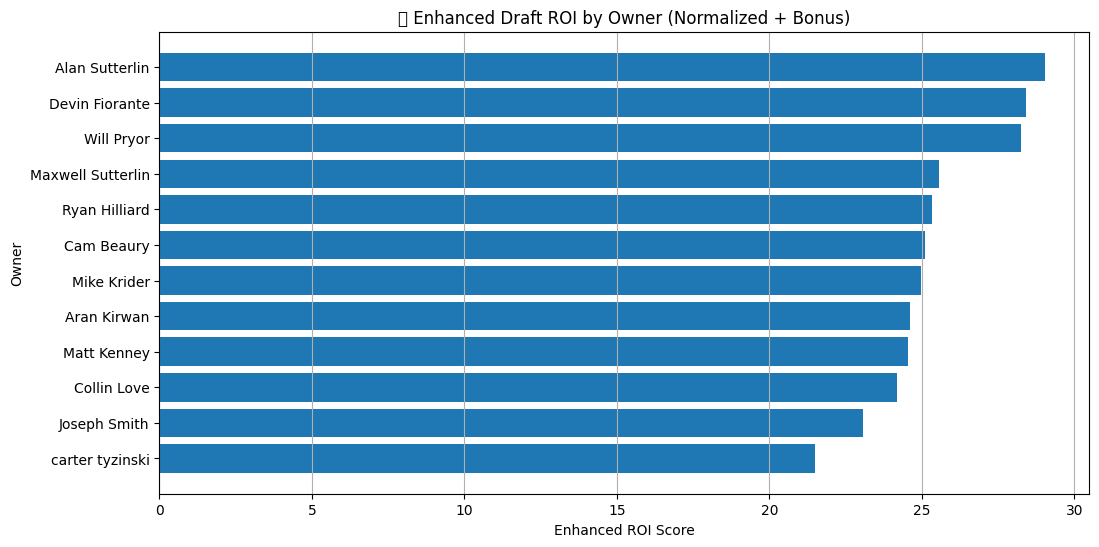

In [135]:
plt.figure(figsize=(12, 6))
plt.barh(enhanced_roi_by_owner.index, enhanced_roi_by_owner.values)
plt.title("🔥 Enhanced Draft ROI by Owner (Normalized + Bonus)")
plt.xlabel("Enhanced ROI Score")
plt.ylabel("Owner")
plt.gca().invert_yaxis()
plt.grid(True, axis='x')
plt.show()

In [136]:
# Group original ROI
roi_total = df.groupby("owner_name")["total_points"].mean()

# Group normalized ROI
roi_normalized = df.groupby("owner_name")["normalized_roi"].mean()

# Group bonus ROI
roi_bonus = df.groupby("owner_name")["bonus_points"].mean()

# Group enhanced ROI
roi_enhanced = df.groupby("owner_name")["enhanced_roi"].mean()

# Combine all into one DataFrame
roi_components = pd.DataFrame({
    "Total ROI": roi_total,
    "Normalized ROI": roi_normalized,
    "Bonus ROI": roi_bonus,
    "Enhanced ROI": roi_enhanced
}).sort_values("Enhanced ROI", ascending=False)

roi_components.head()  # Preview

,Total ROI,Normalized ROI,Bonus ROI,Enhanced ROI
owner_name,,,,
Alan Sutterlin,130.312500,28.043731,0.879121,29.043731
Devin Fiorante,131.500000,26.784098,1.600000,28.405720
Will Pryor,127.500000,27.982481,0.266667,28.268195
Maxwell Sutterlin,133.500000,25.323172,0.219780,25.567075
Ryan Hilliard,123.325581,24.161125,1.098901,25.323915


/Users/arankirwan/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


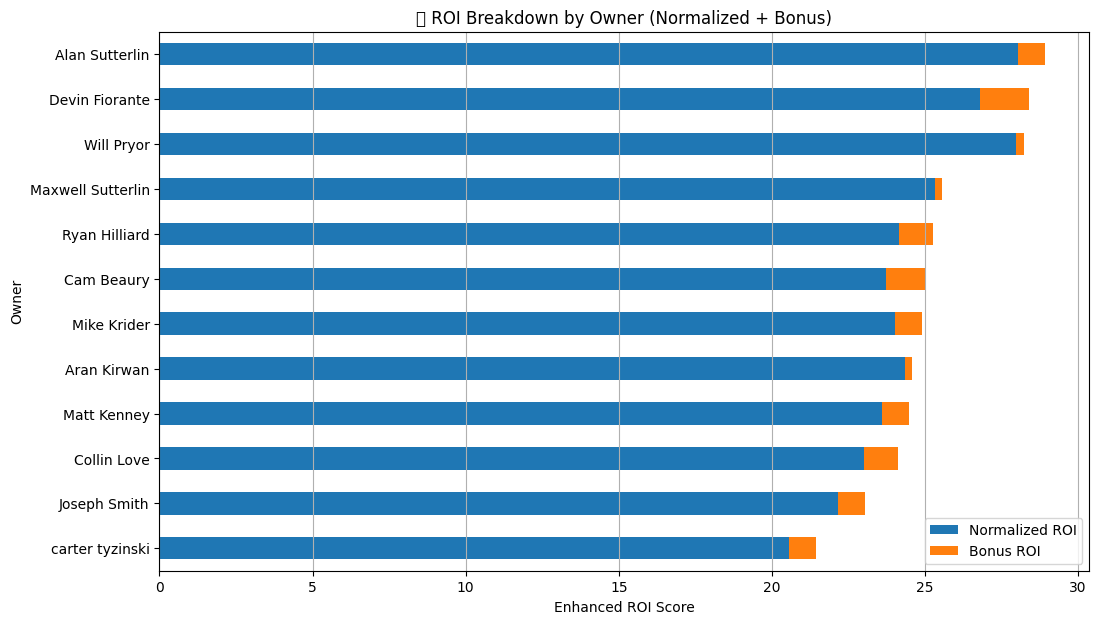

In [137]:
roi_components[["Normalized ROI", "Bonus ROI"]].plot(
    kind="barh", stacked=True, figsize=(12, 7)
)
plt.title("📊 ROI Breakdown by Owner (Normalized + Bonus)")
plt.xlabel("Enhanced ROI Score")
plt.ylabel("Owner")
plt.grid(True, axis='x')
plt.gca().invert_yaxis()
plt.show()

In [138]:
# Rank players by total points (overall rank)
df["player_rank"] = df["total_points"].rank(method="min", ascending=False)
df["player_rank"] = df["player_rank"].fillna(9999).astype(int)

# Rank within position (for DST and Kicker bonuses)
df["position_rank"] = df.groupby("position")["total_points"].rank(method="min", ascending=False)
df["position_rank"] = df["position_rank"].fillna(9999).astype(int)

In [139]:
# Start with zeros
df["bonus"] = 0

# Late-Round Steals
late_steals = df[(df["round"] >= 6) & (df["player_rank"] <= 20)]
df.loc[late_steals.index, "bonus"] += (21 - late_steals["player_rank"]) * 0.5

# High Scorers After Round 5
high_scorers = df[(df["round"] >= 6) & (df["total_points"] > 200)]
df.loc[high_scorers.index, "bonus"] += (high_scorers["total_points"] - 200) / 20

# Top 3 DST / K
top_dsts = df[(df["position"].isin(["D/ST", "K"])) & (df["position_rank"] <= 3)]
df.loc[top_dsts.index, "bonus"] += (4 - top_dsts["position_rank"]) * 2

# Keeper Bonus (Round 1 Only)
keepers = df[(df["round"] == 1) & (df["player_rank"] <= 10)]
df.loc[keepers.index, "bonus"] += (11 - keepers["player_rank"]) * 0.75

/var/folders/kw/n6r34_wd7j73zy9t9br3ms680000gn/T/ipykernel_86466/953872553.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 5.3   3.4   1.05  1.5   5.2   1.95  1.15  3.2  21.45  4.5   1.65  1.65
  4.7   0.6   1.55  2.75  1.25  3.5   0.65 15.45  1.35  0.9   5.75  2.
  4.2   1.15  1.6   4.2   1.65  3.25  4.2   3.35  1.4   0.55  1.75  1.25
  0.2   3.15  3.75  3.75  0.35  1.5   4.15  4.4   1.7   2.75  1.4   0.2
  3.35  1.25  6.6 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[high_scorers.index, "bonus"] += (high_scorers["total_points"] - 200) / 20


/Users/arankirwan/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


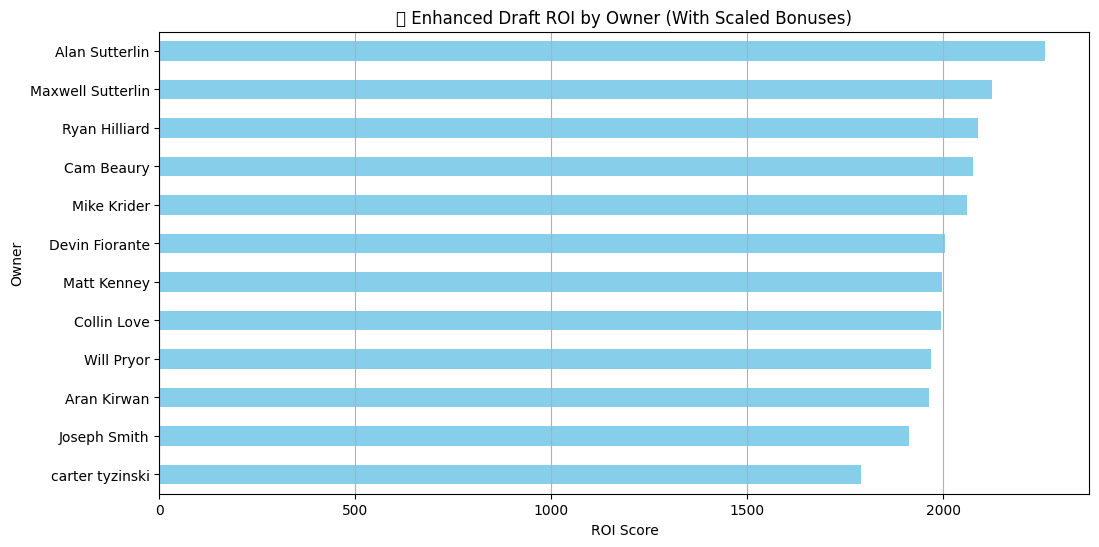

In [140]:
# Add bonus to ROI
df["enhanced_roi"] = df["normalized_roi"] + df["bonus"]

# Renormalize enhanced ROI to a 0–100 scale
min_score = df["enhanced_roi"].min()
max_score = df["enhanced_roi"].max()

df["roi_score"] = 100 * (df["enhanced_roi"] - min_score) / (max_score - min_score)

# Group
enhanced_roi_by_owner = df.groupby("owner_name")["enhanced_roi"].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
enhanced_roi_by_owner.plot(kind="barh", color="skyblue")
plt.title("🏆 Enhanced Draft ROI by Owner (With Scaled Bonuses)")
plt.xlabel("ROI Score")
plt.ylabel("Owner")
plt.gca().invert_yaxis()
plt.grid(True, axis='x')
plt.show()

/Users/arankirwan/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


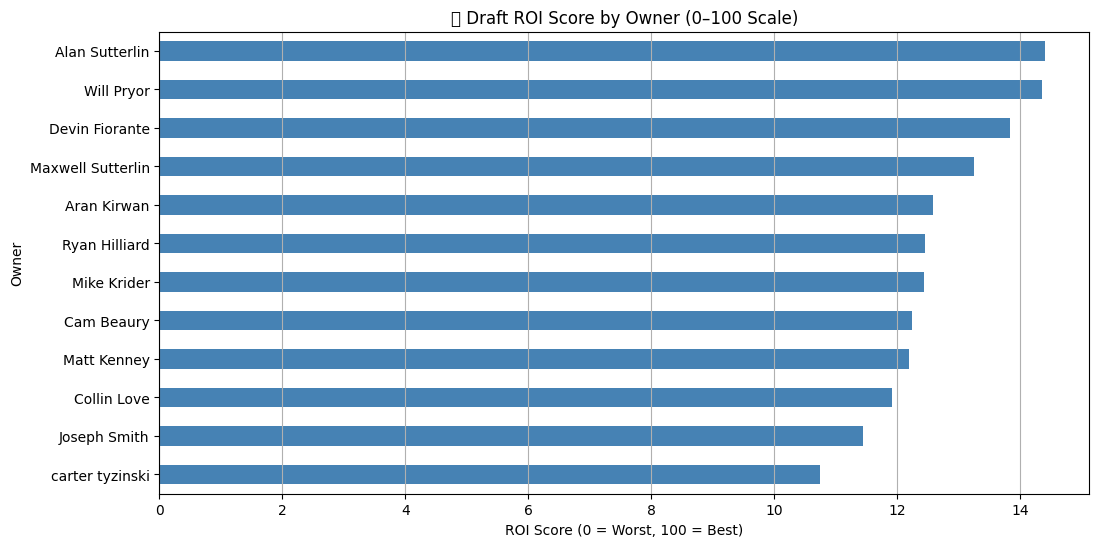

In [141]:
plt.figure(figsize=(12, 6))
roi_by_owner = df.groupby("owner_name")["roi_score"].mean().sort_values()
roi_by_owner.plot(kind="barh", color="steelblue")

plt.title("🎯 Draft ROI Score by Owner (0–100 Scale)")
plt.xlabel("ROI Score (0 = Worst, 100 = Best)")
plt.ylabel("Owner")
plt.grid(True, axis="x")
#plt.gca().invert_yaxis()
plt.show()

In [142]:
roi_by_season = df.groupby(["owner_name", "season_year"])["roi_score"].sum().reset_index()
roi_by_season = roi_by_season.sort_values("roi_score", ascending=False)

/var/folders/kw/n6r34_wd7j73zy9t9br3ms680000gn/T/ipykernel_86466/1493310205.py:14: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/arankirwan/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


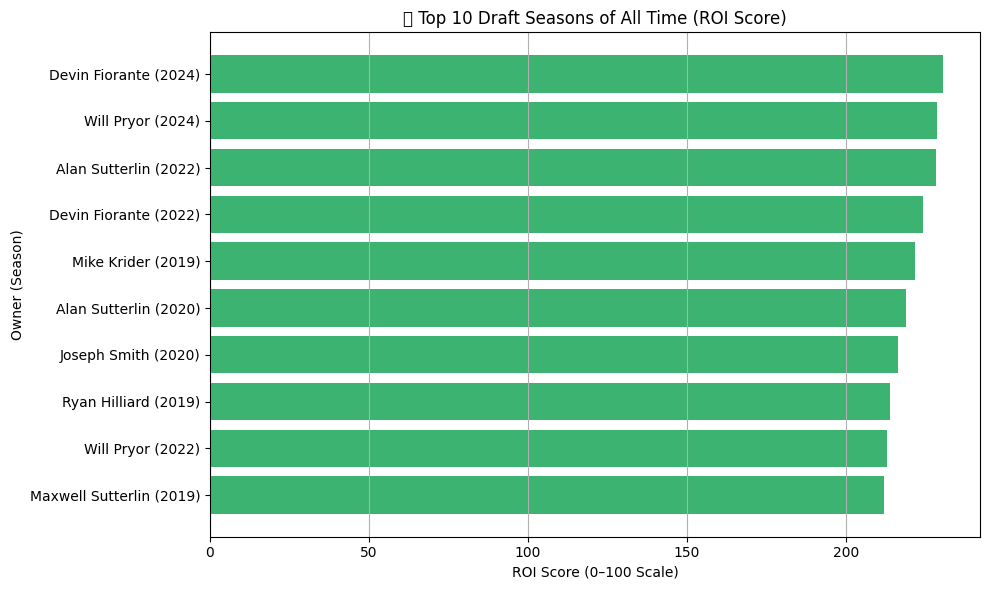

In [143]:
top_seasons = roi_by_season.head(10)

plt.figure(figsize=(10, 6))
plt.barh(
    top_seasons["owner_name"] + " (" + top_seasons["season_year"].astype(str) + ")",
    top_seasons["roi_score"],
    color="mediumseagreen"
)
plt.title("🏆 Top 10 Draft Seasons of All Time (ROI Score)")
plt.xlabel("ROI Score (0–100 Scale)")
plt.ylabel("Owner (Season)")
plt.gca().invert_yaxis()
plt.grid(True, axis="x")
plt.tight_layout()
plt.show()

In [144]:
# Compute Player ROI Score
df["player_roi"] = df["total_points"] / df["overall_pick"]

# Filter for meaningful picks (exclude missing values and undrafted)
player_roi_df = df[df["player_roi"].notnull()]

# Get top ROI picks of all time
top_players = (
    player_roi_df
    .sort_values(by="player_roi", ascending=False)
    .head(15)
    [["player_name", "season_year", "owner_name", "round", "pick", "total_points", "player_roi"]]
)

top_players.reset_index(drop=True, inplace=True)
top_players

KeyError: 'overall_pick'

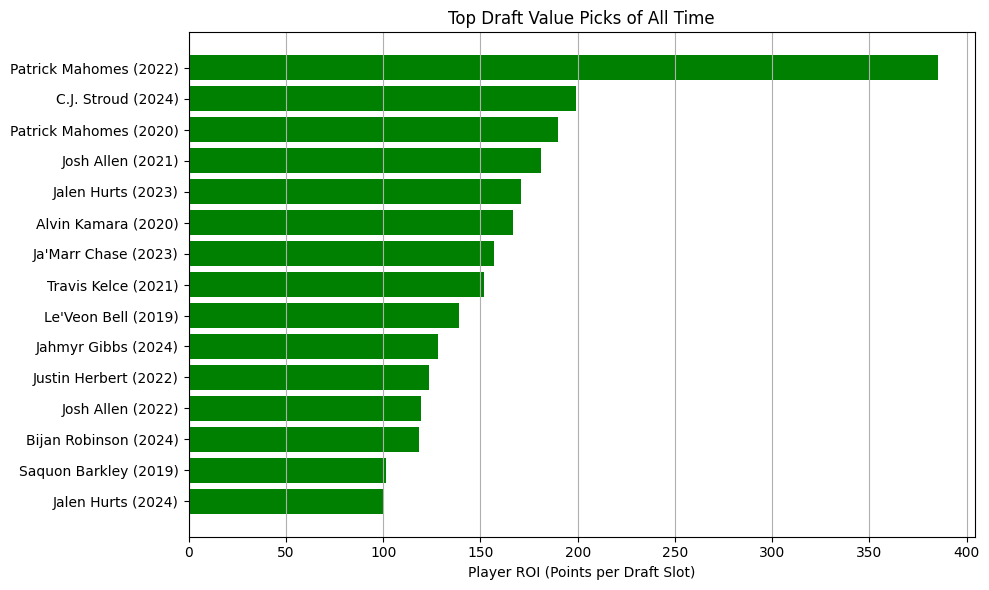

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(top_players["player_name"] + " (" + top_players["season_year"].astype(str) + ")", 
         top_players["player_roi"], color="green")
plt.xlabel("Player ROI (Points per Draft Slot)")
plt.title("Top Draft Value Picks of All Time")
plt.gca().invert_yaxis()
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [ ]:
# Filter top ROI picks to just QBs
player_roi_df_qb = player_roi_df[player_roi_df["position"] == "QB"]

top_qb_players = (
    player_roi_df_qb
    .sort_values(by="player_roi", ascending=False)
    .head(15)[["player_name", "owner_name", "season_year", "round", "pick", "total_points", "player_roi"]]
)

top_qb_players.reset_index(drop=True, inplace=True)

In [ ]:
# Filter top ROI picks to just WRs
player_roi_df_wr = player_roi_df[player_roi_df["position"] == "WR"]

top_wr_players = (
    player_roi_df_wr
    .sort_values(by="player_roi", ascending=False)
    .head(15)[["player_name", "owner_name", "season_year", "round", "pick", "total_points", "player_roi"]]
)

top_wr_players.reset_index(drop=True, inplace=True)

In [ ]:
# Filter for late round picks only
late_round_roi_df = player_roi_df[player_roi_df["round"] >= 6]

top_late_round_players = (
    late_round_roi_df
    .sort_values(by="player_roi", ascending=False)
    .head(15)[["player_name", "owner_name", "season_year", "round", "pick", "total_points", "player_roi"]]
)

top_late_round_players.reset_index(drop=True, inplace=True)

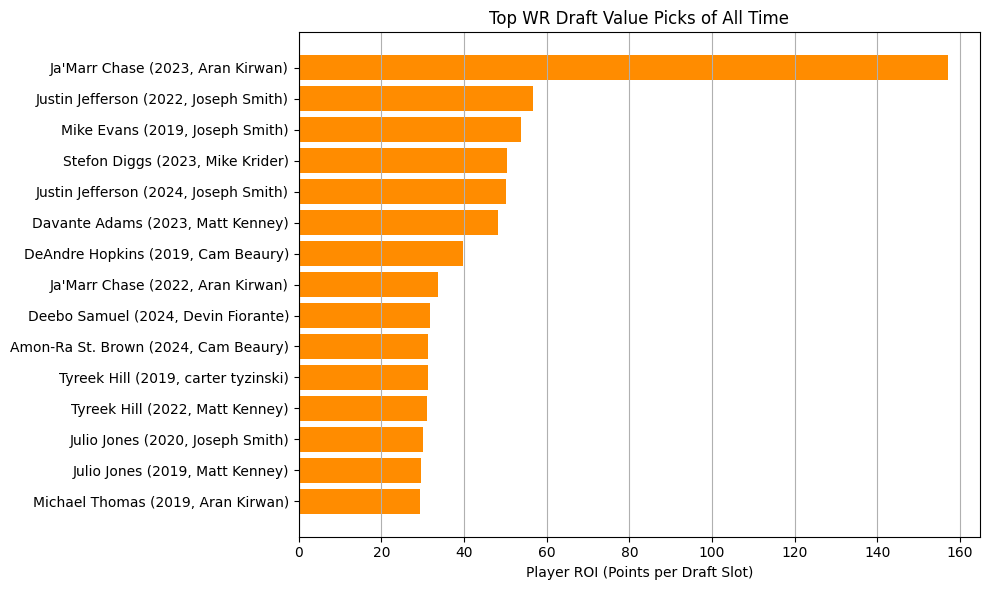

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(
    top_wr_players["player_name"] + " (" + top_wr_players["season_year"].astype(str) + ", " + top_wr_players["owner_name"] + ")",
    top_wr_players["player_roi"],
    color="darkorange"
)
plt.xlabel("Player ROI (Points per Draft Slot)")
plt.title("Top WR Draft Value Picks of All Time")
plt.gca().invert_yaxis()
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [ ]:
# Filter to only WRs
player_roi_df_wr = player_roi_df[player_roi_df["position"] == "WR"]

# Get top 15 WR ROI picks
top_wr_players = (
    player_roi_df_wr
    .sort_values(by="player_roi", ascending=False)
    .head(15)[["player_name", "owner_name", "season_year", "round", "pick", "total_points", "player_roi"]]
)

top_wr_players.reset_index(drop=True, inplace=True)

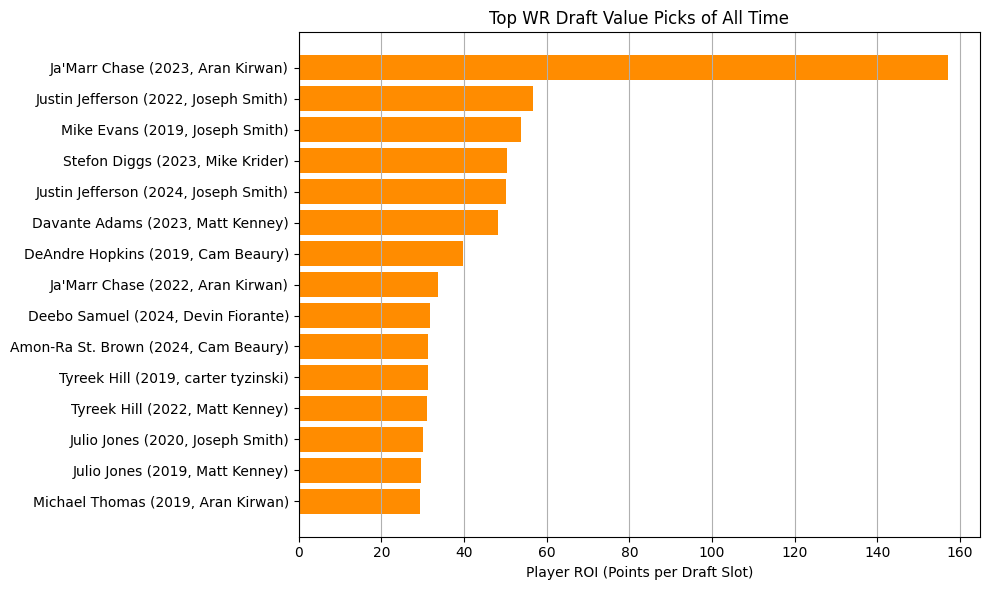

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(
    top_wr_players["player_name"] + " (" + top_wr_players["season_year"].astype(str) + ", " + top_wr_players["owner_name"] + ")",
    top_wr_players["player_roi"],
    color="darkorange"
)
plt.xlabel("Player ROI (Points per Draft Slot)")
plt.title("Top WR Draft Value Picks of All Time")
plt.gca().invert_yaxis()
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [160]:
import sqlite3
import pandas as pd

# Reconnect to database — make sure this matches your real path
conn = sqlite3.connect("/Users/arankirwan/fantasy-football-data/db/fantasy_football.db")

def list_columns(table_name):
    query = f"PRAGMA table_info({table_name})"
    df = pd.read_sql_query(query, conn)
    print(f"🧱 Columns in `{table_name}`:")
    print(df[['name', 'type']])
    print()

In [161]:
list_columns("draft_results")
list_columns("players")
list_columns("rosters")
list_columns("box_scores")
list_columns("teams")

🧱 Columns in `draft_results`:
          name     type
0  season_year  INTEGER
1        round  INTEGER
2         pick  INTEGER
3  pick_number  INTEGER
4      team_id  INTEGER
5    player_id     TEXT

🧱 Columns in `players`:
        name  type
0  player_id  TEXT
1       name  TEXT
2   position  TEXT
3       team  TEXT
4   pro_team  TEXT

🧱 Columns in `rosters`:
               name     type
0       season_year  INTEGER
1           team_id  INTEGER
2         player_id     TEXT
3              week  INTEGER
4     slot_position     TEXT
5            points     REAL
6  projected_points     REAL
7        is_starter  INTEGER

🧱 Columns in `box_scores`:
               name     type
0       season_year  INTEGER
1              week  INTEGER
2           team_id  INTEGER
3         player_id  INTEGER
4     slot_position     TEXT
5            points     REAL
6  projected_points     REAL
7        is_starter  BOOLEAN

🧱 Columns in `teams`:
              name     type
0      season_year  INTEGER
1        

In [185]:
import sqlite3
import pandas as pd

# Step 1: Connect to DB
conn = sqlite3.connect("/Users/arankirwan/fantasy-football-data/db/fantasy_football.db")

# Step 2: Write your query
query = """
SELECT
  dr.season_year,
  p.name AS player_name,
  t.owner_name,
  dr.round,
  dr.pick_number,
  r.points,
  (r.points - dr.pick_number) AS roi_score
FROM draft_results dr
JOIN players p ON dr.player_id = p.player_id
JOIN teams t ON dr.team_id = t.team_id
JOIN rosters r ON
  dr.player_id = r.player_id AND
  dr.season_year = r.season_year AND
  dr.team_id = r.team_id
WHERE p.position = 'WR'
GROUP BY dr.season_year, dr.player_id
ORDER BY roi_score DESC
LIMIT 15;
"""

# Step 3: Read into DataFrame
df = pd.read_sql_query(query, conn)

# Step 4: Close the connection
conn.close()

# Step 5: Preview results
df.head()

,season_year,player_name,owner_name,round,pick_number,points,roi_score
0,2019,Julian Edelman,"Mike Krider, Michael Krider",4,None,148.0,None
1,2019,Emmanuel Sanders,"Mike Krider, Michael Krider",12,None,117.0,None
2,2019,A.J. Green,Alan Sutterlin,10,None,0.0,None
3,2019,T.Y. Hilton,carter tyzinski,8,None,75.0,None
4,2019,DeAndre Hopkins,Cam Beaury,1,None,157.0,None


In [191]:
query = """
SELECT 
    season_year,
    player_id,
    round,
    pick_number,
    points
FROM draft_results
WHERE season_year = 2019
LIMIT 10;
"""

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

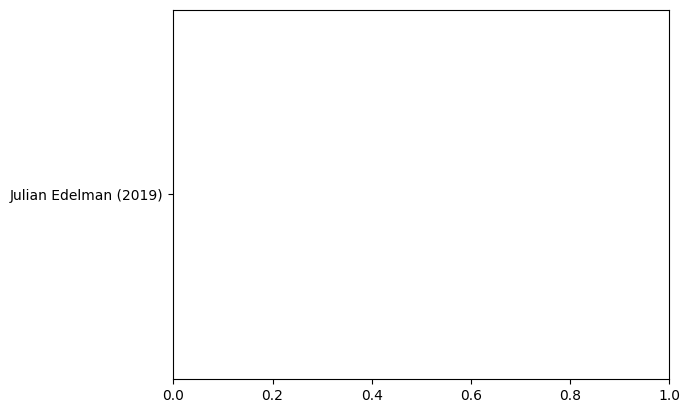

In [178]:
import matplotlib.pyplot as plt

plt.barh(df['player_name'] + " (" + df['season_year'].astype(str) + ")", df['roi_score'])
plt.xlabel("ROI (Points - Draft Pick #)")
plt.title("Top WR Draft ROI Picks")
plt.gca().invert_yaxis()
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()